# Predicting Breast Cancer Subtypes Using METABRIC Data

In this notebook, we explore how to use real-world biomedical data from the METABRIC dataset to predict breast cancer molecular subtypes based on clinical and molecular features. We will build machine learning models and evaluate them using a variety of performance metrics and visualizations.

In [1]:
# Install dependencies
!pip install pandas matplotlib seaborn scikit-learn xgboost -q

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

## Load and Preview the METABRIC Dataset

In [6]:
df = pd.read_csv('METABRIC_RNA_Mutation.csv')  # Ensure this file is uploaded
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


## Data Cleaning and Preprocessing

In [9]:
# Drop columns with too many missing values or irrelevant IDs
df.drop(columns=['patient_id'], inplace=True)

# Drop rows with missing target
df = df.dropna(subset=['pam50_+_claudin-low_subtype'])

# Encode categorical variables
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Fill missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Split features and target
X = df.drop(columns=['pam50_+_claudin-low_subtype'])
y = df['pam50_+_claudin-low_subtype']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train Random Forest and XGBoost Models

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

## Model Evaluation Metrics

Model: Random Forest

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        40
           1       0.84      0.73      0.78        44
           2       0.77      0.88      0.82       136
           3       0.76      0.87      0.81        92
           4       0.00      0.00      0.00         1
           5       0.88      0.25      0.39        28
           6       0.83      0.75      0.79        40

    accuracy                           0.79       381
   macro avg       0.70      0.61      0.63       381
weighted avg       0.79      0.79      0.77       381



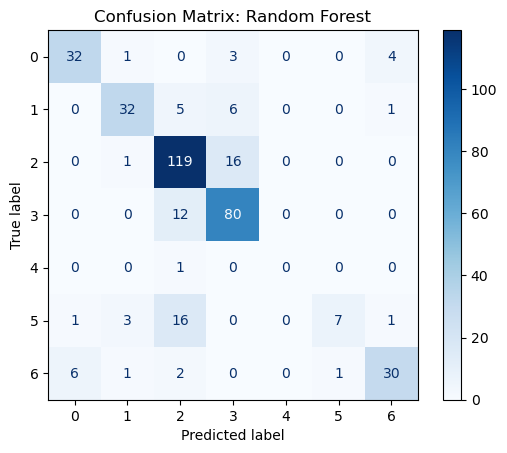

Model: XGBoost

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        40
           1       0.79      0.84      0.81        44
           2       0.82      0.89      0.86       136
           3       0.85      0.87      0.86        92
           4       0.00      0.00      0.00         1
           5       0.65      0.39      0.49        28
           6       0.86      0.75      0.80        40

    accuracy                           0.82       381
   macro avg       0.69      0.66      0.67       381
weighted avg       0.82      0.82      0.82       381



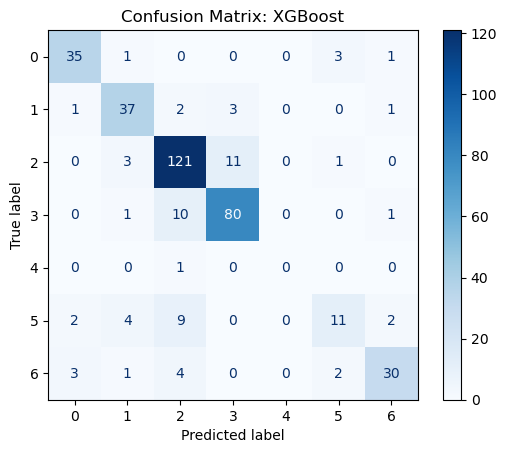

In [15]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"Model: {model_name}\n")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

## Feature Importance from XGBoost

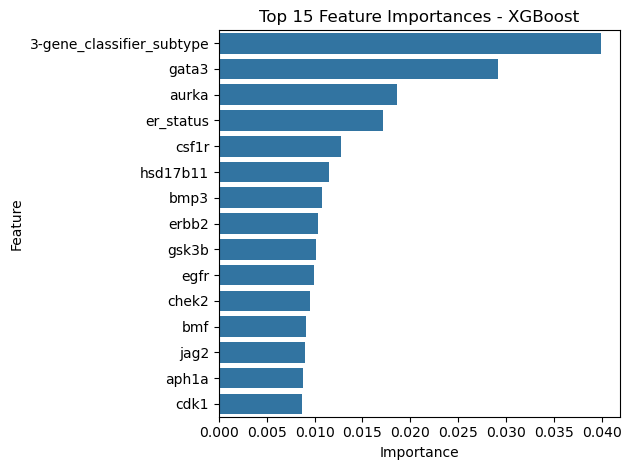

In [18]:
importances = xgb.feature_importances_
feat_df = pd.DataFrame({'Feature': df.drop(columns=['pam50_+_claudin-low_subtype']).columns, 'Importance': importances})
feat_df.sort_values('Importance', ascending=False, inplace=True)
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature')
plt.title('Top 15 Feature Importances - XGBoost')
plt.tight_layout()
plt.show()

## SHAP-based Interpretability for XGBoost Model

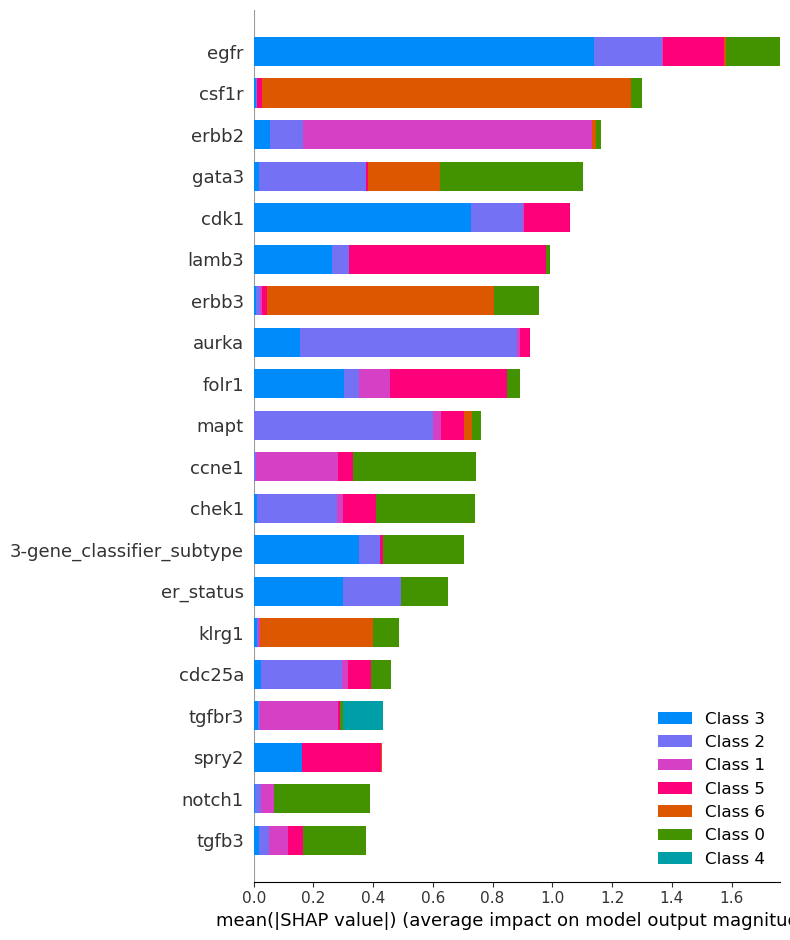

In [21]:
import shap
explainer = shap.Explainer(xgb)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, features=X_test, feature_names=df.drop(columns=['pam50_+_claudin-low_subtype']).columns)

## Hyperparameter Optimization with Grid Search

In [25]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(eval_metric='mlogloss'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters found: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


## Evaluation of Optimized XGBoost Model

Model: Optimized XGBoost

              precision    recall  f1-score   support

           0       0.88      0.93      0.90        40
           1       0.86      0.86      0.86        44
           2       0.83      0.88      0.85       136
           3       0.82      0.87      0.85        92
           4       0.00      0.00      0.00         1
           5       0.65      0.39      0.49        28
           6       0.89      0.80      0.84        40

    accuracy                           0.83       381
   macro avg       0.70      0.68      0.69       381
weighted avg       0.83      0.83      0.83       381



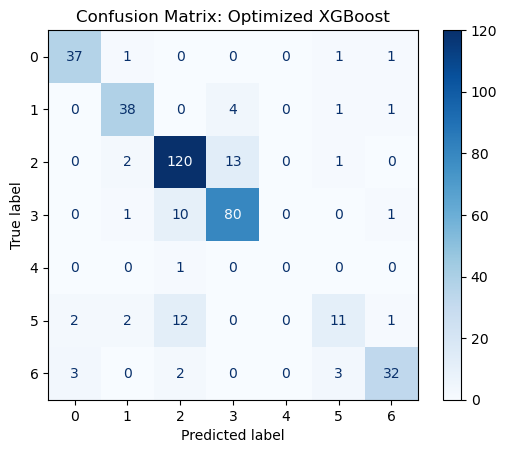

In [27]:
evaluate_model(y_test, y_pred_best, "Optimized XGBoost")

## Cross-Validation Score Visualization

Cross-validation scores: [0.76721311 0.70819672 0.76721311 0.80263158 0.73026316]
Mean CV Accuracy: 0.7551


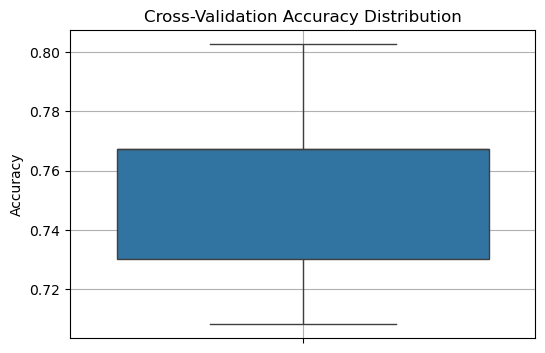

In [29]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

plt.figure(figsize=(6, 4))
sns.boxplot(data=cv_scores)
plt.title("Cross-Validation Accuracy Distribution")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

## Export Best Model for Deployment

In [31]:
import joblib

# Save the trained model to a file
joblib.dump(best_model, 'optimized_xgb_model.pkl')
print("Model saved as optimized_xgb_model.pkl")

Model saved as optimized_xgb_model.pkl
